<a href="https://colab.research.google.com/github/Dhivyagkrishnan/QLSTM_for_stock_analysis/blob/main/LSTM_%2BQLSTM_AAPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:

!pip install utils
!pip install mxnet

In [81]:
import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

In [83]:
df = pd.read_csv('dataset_AAPL_prediction.csv')
df = df.drop(['Date' ,'Unnamed: 0'], axis=1)
df

,Close,High,Low,Open,Volume,Ticker,FT3,FT6,FT9,ARIMA,...,SPY,AMZN,NVDA,TSLA,META,INTC,ADBE,NYSE,NASDAQ,Close_lead1
0,87.918793,88.013573,85.367111,85.845856,130646000,AAPL,164.406568,149.935408,145.477595,87.918793,...,283.488220,134.018997,9.169775,67.290001,219.436157,51.944389,424.200012,11777.080078,9874.150391,88.652687
1,88.652687,88.939453,87.486207,87.505645,140223200,AAPL,163.840928,148.959016,144.074346,88.652687,...,287.119568,137.940994,9.466547,71.987335,225.831070,53.335041,435.309998,11893.780273,10058.769531,88.485039
2,88.485039,89.274845,88.436440,88.730489,110737200,AAPL,163.275905,147.990596,142.686206,88.485039,...,289.130768,143.934998,9.498687,74.641998,236.253891,52.425766,439.809998,11901.549805,10154.629883,88.485039
3,88.485039,90.030633,88.370828,89.393929,114041600,AAPL,162.711560,147.030407,141.314007,88.485039,...,290.723053,144.514999,9.580671,80.577332,232.146423,52.711037,442.950012,11991.519531,10207.629883,90.852005
4,90.852005,91.321027,89.884794,89.916387,118655600,AAPL,162.147954,146.078704,139.958564,90.852005,...,295.210999,152.852005,9.806925,91.438667,238.968994,53.076527,452.589996,12160.009766,10433.650391,90.570107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,201.000000,201.699997,196.860001,198.240005,96813500,AAPL,167.809872,155.946161,154.166099,196.494189,...,594.280029,209.690002,143.850006,322.160004,682.349976,21.080000,376.920013,19868.359375,19447.410156,201.500000
1251,201.500000,202.300003,198.960007,201.630005,55814300,AAPL,167.241837,154.927598,152.690407,201.202717,...,600.150024,208.470001,144.169998,348.679993,698.530029,21.190001,380.119995,20008.179688,19630.970703,200.300003
1252,200.300003,203.440002,200.199997,202.589996,54064000,AAPL,166.674047,153.915371,151.224562,201.628095,...,606.780029,212.770004,147.899994,340.470001,712.200012,22.549999,382.339996,20217.339844,19912.529297,201.559998
1253,201.559998,203.669998,200.619995,201.449997,39525700,AAPL,166.106563,152.909762,149.769469,200.088599,...,607.119995,211.990005,154.309998,327.549988,708.679993,22.200001,387.549988,20087.449219,19973.550781,201.000000


In [84]:
target = "Close_lead1"

In [85]:
features = list(df.columns.difference(["Close", 'Close_lead1']))
features

['ADBE',
 'AMZN',
 'ARIMA',
 'FT3',
 'FT6',
 'FT9',
 'GOOG',
 'High',
 'INTC',
 'Low',
 'META',
 'MSFT',
 'NASDAQ',
 'NVDA',
 'NYSE',
 'Open',
 'QQQ',
 'SNP',
 'SPY',
 'TSLA',
 'Ticker',
 'Volume']

 DATA PROCESSING

In [86]:
size = int(len(df) * 0.67)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [88]:
 # Identify only numeric columns (excluding the target for now)
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Normalize numeric columns in both train and test
for c in numeric_cols:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev  # Use train stats for test set normalization


In [89]:
# Include target if needed
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

for c in numeric_cols:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev


In [90]:
print(df_train.dtypes)


Close          float64
High           float64
Low            float64
Open           float64
Volume         float64
Ticker          object
FT3            float64
FT6            float64
FT9            float64
ARIMA          float64
SNP            float64
MSFT           float64
GOOG           float64
QQQ            float64
SPY            float64
AMZN           float64
NVDA           float64
TSLA           float64
META           float64
INTC           float64
ADBE           float64
NYSE           float64
NASDAQ         float64
Close_lead1    float64
dtype: object


In [91]:
df_train = df_train.select_dtypes(include=[np.number])
df_test = df_test.select_dtypes(include=[np.number])


In [92]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [93]:
from Factory import SequenceDataset

In [95]:
 import torch
from torch.utils.data import DataLoader

# ✅ Rebuild feature list from df_train after cleaning/dropping object columns
features = [col for col in df_train.columns if col != target and df_train[col].dtype in ['float64', 'int64']]

# ✅ Set random seed
torch.manual_seed(101)

# ✅ Parameters
batch_size = 1
sequence_length = 3

# ✅ Create datasets
train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

# ✅ Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Sample output for shape check
X, y = next(iter(train_loader))
print("✅ Features shape:", X.shape)
print("✅ Target shape:", y.shape)


✅ Features shape: torch.Size([1, 3, 22])
✅ Target shape: torch.Size([1])


CLASSICAL LSTM


In [96]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [97]:
from Factory import ShallowRegressionLSTM

In [98]:

learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [99]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
test_loss = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print()
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------
Test loss: 6.722626046028482

Epoch 0
---------
Train loss: 0.6866374431379197
Test loss: 5.263712991545179

Epoch 1
---------
Train loss: 0.1763462879554754
Test loss: 4.2581966594218805

Epoch 2
---------
Train loss: 0.0705195173638602
Test loss: 3.579584458288793

Epoch 3
---------
Train loss: 0.05217679873313087
Test loss: 3.3221800066303966

Epoch 4
---------
Train loss: 0.0426051636480094
Test loss: 2.9233741906406525

Epoch 5
---------
Train loss: 0.0353543847872831
Test loss: 2.5704610687579086

Epoch 6
---------
Train loss: 0.03065014657873766
Test loss: 2.4390415864583215

Epoch 7
---------
Train loss: 0.027352986275809944
Test loss: 2.4762381241476783

Epoch 8
---------
Train loss: 0.0249095976192384
Test loss: 2.5206535002624677

Epoch 9
---------
Train loss: 0.023082577012928696
Test loss: 2.4718166604195755

Epoch 10
---------
Train loss: 0.02194502287398689
Test loss: 2.4540638198568714

Epoch 11
---------
Train loss: 0.020909067732947005
Test los

In [100]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [101]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Close_lead1  Model forecast
0       -2.481063       -2.461571
1       -2.488373       -2.446253
2       -2.488373       -2.430277
3       -2.385162       -2.412596
4       -2.397454       -2.379621
...           ...             ...
1250     2.439624        1.464962
1251     2.387298        1.471797
1252     2.442240        1.479665
1253     2.417821        1.484509
1254     2.421310        1.477632

[1256 rows x 2 columns]


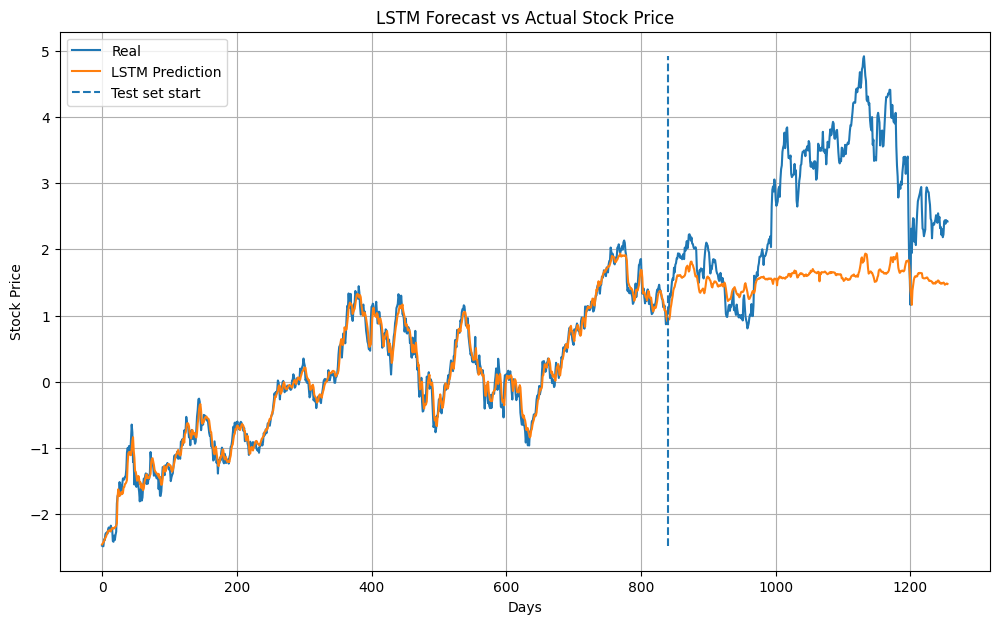

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Auto-match length of df_out
plt.plot(range(len(df_out)), df_out["Close_lead1"], label="Real")
plt.plot(range(len(df_out)), df_out["Model forecast"], label="LSTM Prediction")

plt.ylabel('Stock Price')
plt.xlabel('Days')

# Add vertical line at correct test set start if `size` is valid
if 'size' in locals() and isinstance(size, int) and size < len(df_out):
    plt.vlines(size, ymin=min(df_out["Close_lead1"].min(), df_out["Model forecast"].min()),
               ymax=max(df_out["Close_lead1"].max(), df_out["Model forecast"].max()),
               label="Test set start", linestyles="dashed")

plt.legend()
plt.grid(True)
plt.title("LSTM Forecast vs Actual Stock Price")
plt.show()


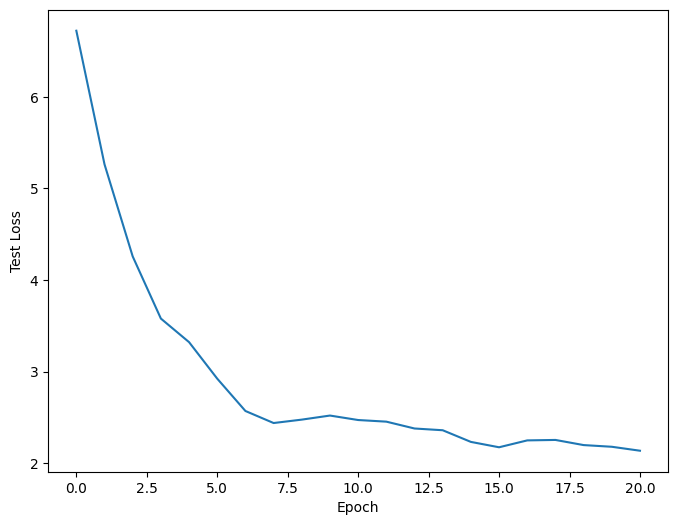

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(range(21), classical_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

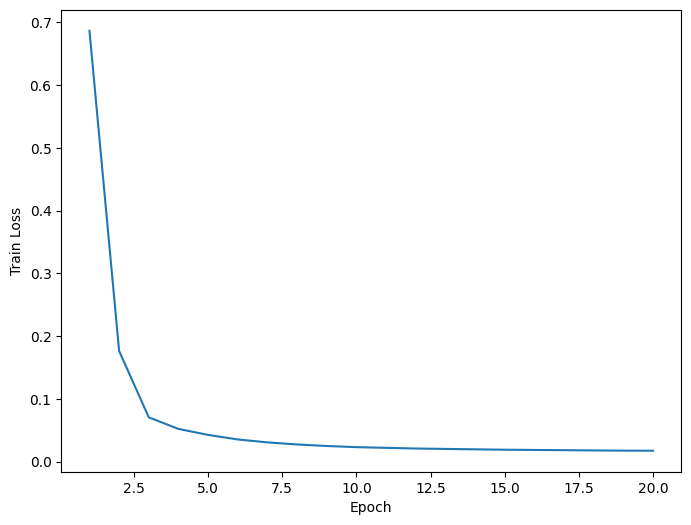

In [105]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), classical_loss_train)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()

Running the QLSTM

In [106]:
from Factory import QShallowRegressionLSTM

In [107]:
learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [109]:
 # ✅ Single script version: No Factory.py needed

import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import numpy as np

######################################
# Dataset class
######################################
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

######################################
# Quantum LSTM cell
######################################
class QLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits=4, n_qlayers=1, n_vrotations=3,
                 batch_first=True, return_sequences=False, return_state=False, backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.n_vrotations = n_vrotations
        self.backend = backend

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def ansatz(params, wires_type):
            for i in range(1, 3):
                for j in range(self.n_qubits):
                    qml.CNOT(wires=[wires_type[j], wires_type[(j + i) % self.n_qubits]])
            for i in range(self.n_qubits):
                qml.RX(params[0][i], wires=wires_type[i])
                qml.RY(params[1][i], wires=wires_type[i])
                qml.RZ(params[2][i], wires=wires_type[i])

        def VQC(features, weights, wires_type):
            features = features.view(-1)
            ry_params = [torch.arctan(f) for f in features]
            rz_params = [torch.arctan(f ** 2) for f in features]
            for i in range(len(wires_type)):
                wire = wires_type[i]
                qml.Hadamard(wires=wire)
                ry = ry_params[i] if i < len(ry_params) else 0.0
                rz = rz_params[i] if i < len(rz_params) else 0.0
                qml.RY(ry, wires=wire)
                qml.RZ(rz, wires=wire)
            qml.layer(ansatz, self.n_qlayers, weights, wires_type=wires_type)

        def _circuit(inputs, weights, wires):
            VQC(inputs, weights, wires)
            return [qml.expval(qml.PauliZ(wires=w)) for w in wires]

        self.qlayer_forget = qml.QNode(lambda inputs, weights: _circuit(inputs, weights, self.wires_forget), self.dev_forget, interface="torch")
        self.qlayer_input = qml.QNode(lambda inputs, weights: _circuit(inputs, weights, self.wires_input), self.dev_input, interface="torch")
        self.qlayer_update = qml.QNode(lambda inputs, weights: _circuit(inputs, weights, self.wires_update), self.dev_update, interface="torch")
        self.qlayer_output = qml.QNode(lambda inputs, weights: _circuit(inputs, weights, self.wires_output), self.dev_output, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, self.n_vrotations, self.n_qubits)}
        self.clayer_in = nn.Linear(self.concat_size, self.n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = nn.Linear(self.n_qubits, self.hidden_size)

    def forward(self, x, init_states=None):
        if self.batch_first:
            batch_size, seq_length, _ = x.size()
        else:
            seq_length, batch_size, _ = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)
            c_t = torch.zeros(batch_size, self.hidden_size)
        else:
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            x_t = x[:, t, :]
            v_t = torch.cat((h_t, x_t), dim=1)
            y_t = self.clayer_in(v_t)
            y_t = y_t[:, :self.n_qubits].contiguous()

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t)))

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

######################################
# Quantum LSTM wrapper for regression
######################################
class QShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits=n_qubits,
            n_qlayers=n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()
        return out


In [110]:
Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=16, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=0.05)

quantum_loss_train = []
quantum_loss_test = []

print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print(f"Test Loss: {test_loss:.4f} | Time: {end - start:.2f} sec")
quantum_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"\nEpoch {ix_epoch + 1}/20\n--------------------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Time: {end - start:.2f} sec")
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)


Untrained test
--------
Test loss: 9.089244616893401
Test Loss: 9.0892 | Time: 107.86 sec

Epoch 1/20
--------------------
Train loss: 0.1237947722442395
Test loss: 1.6430164110463208
Train Loss: 0.1238 | Test Loss: 1.6430 | Time: 510.59 sec

Epoch 2/20
--------------------
Train loss: 0.040564877563201915
Test loss: 1.4687725047699023
Train Loss: 0.0406 | Test Loss: 1.4688 | Time: 513.68 sec

Epoch 3/20
--------------------
Train loss: 0.030600673534025027
Test loss: 1.3676298555824458
Train Loss: 0.0306 | Test Loss: 1.3676 | Time: 515.18 sec

Epoch 4/20
--------------------
Train loss: 0.023483735856958832
Test loss: 1.2276440178765615
Train Loss: 0.0235 | Test Loss: 1.2276 | Time: 509.24 sec

Epoch 5/20
--------------------
Train loss: 0.020831987456949416
Test loss: 1.191660152086899
Train Loss: 0.0208 | Test Loss: 1.1917 | Time: 513.67 sec

Epoch 6/20
--------------------
Train loss: 0.019684195901032913
Test loss: 1.1670870009575536
Train Loss: 0.0197 | Test Loss: 1.1671 | Time: 

In [111]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

      Close_lead1  Model forecast
0       -2.481063       -2.335026
1       -2.488373       -2.328584
2       -2.488373       -2.324941
3       -2.385162       -2.316257
4       -2.397454       -2.295780
...           ...             ...
1250     2.439624        2.302299
1251     2.387298        2.309716
1252     2.442240        2.312045
1253     2.417821        2.313435
1254     2.421310        2.314504

[1256 rows x 2 columns]


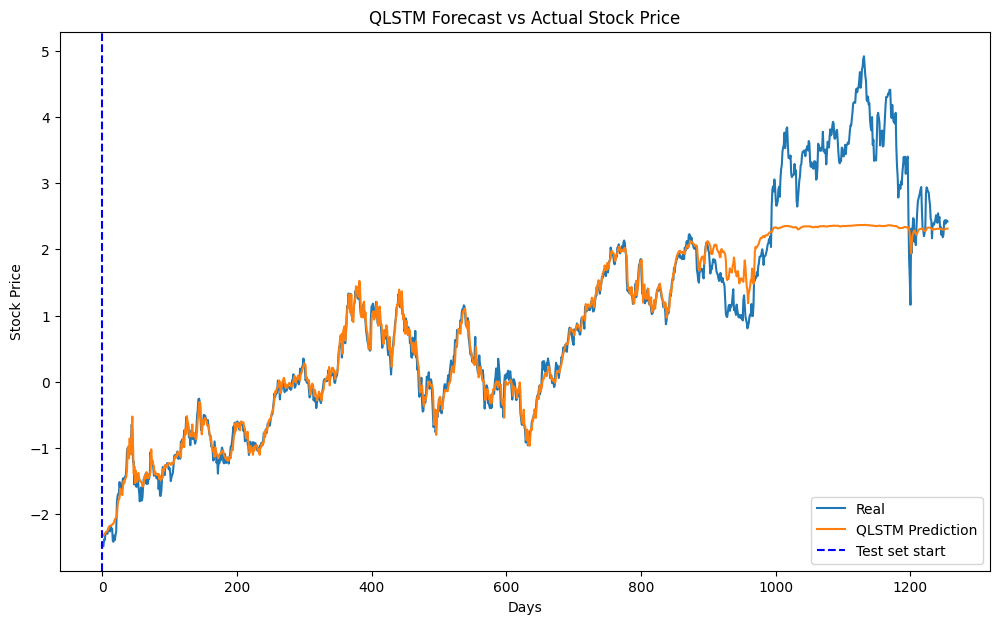

In [115]:
 plt.figure(figsize=(12, 7))

# Plot only the lengths that match
plt.plot(range(len(df_out_Q["Close_lead1"])), df_out_Q["Close_lead1"], label="Real")
plt.plot(range(len(df_out_Q["Model forecast"])), df_out_Q["Model forecast"], label="QLSTM Prediction")

plt.ylabel('Stock Price')
plt.xlabel('Days')

# Set the correct position for the test set start line (adjust "size" accordingly)
plt.axvline(x=len(df_out_Q["Close_lead1"]) - len(df_out_Q["Model forecast"]), color='blue', linestyle='dashed', label='Test set start')

plt.legend()
plt.title("QLSTM Forecast vs Actual Stock Price")
plt.show()


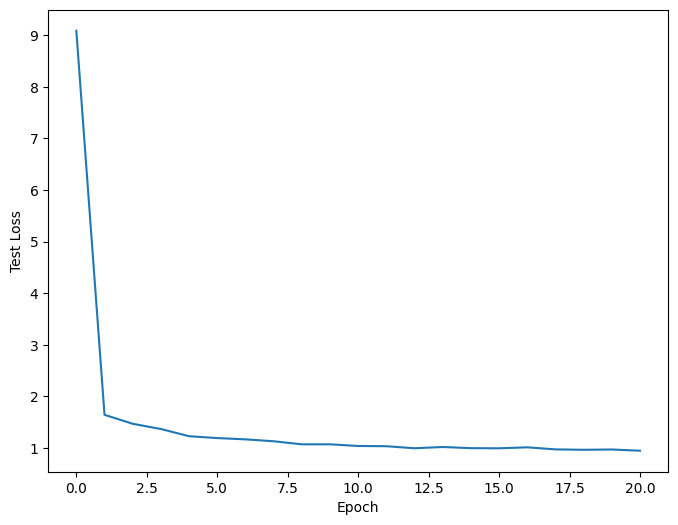

In [116]:
plt.figure(figsize=(8, 6))
plt.plot(range(21), quantum_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

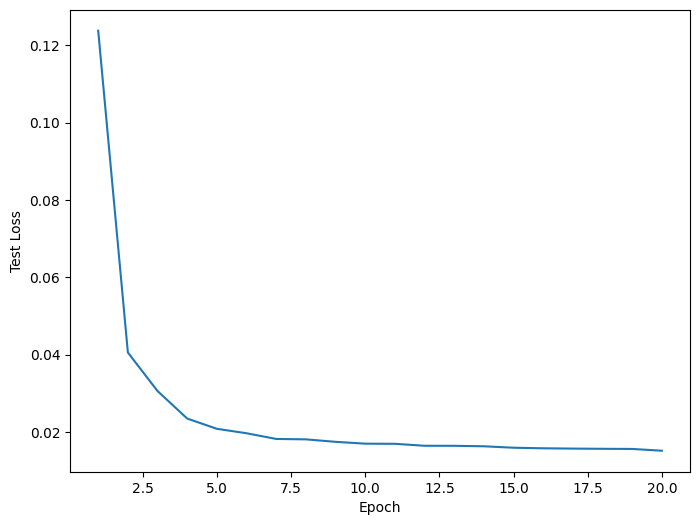

In [117]:
plt.figure(figsize=(8, 6))
plt.plot(range(1,21), quantum_loss_train)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

Comparison between Classical LSTM and QLSTM

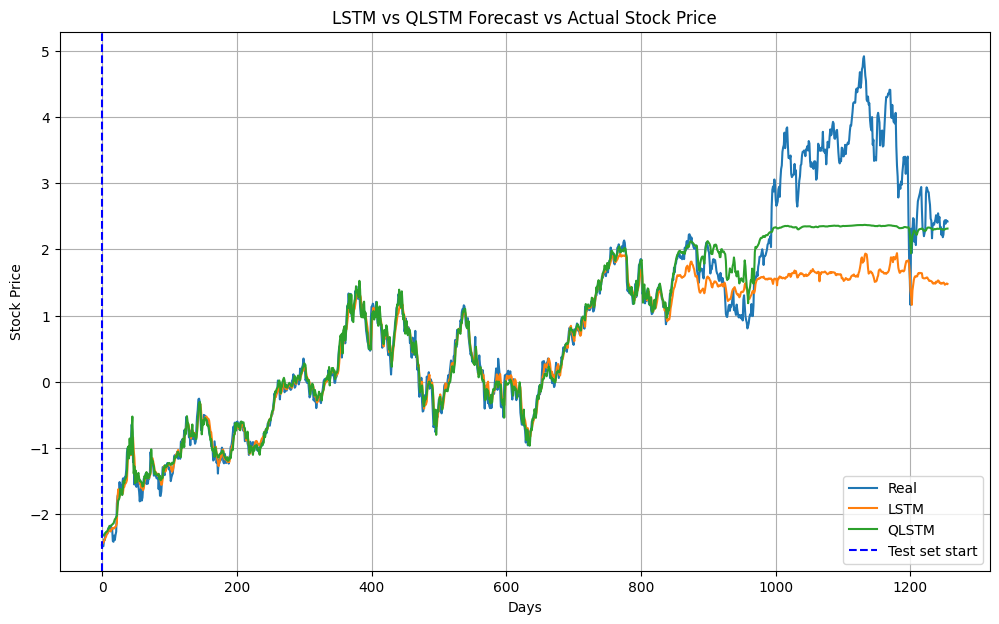

In [119]:
 plt.figure(figsize=(12, 7))

# Plot the real values (full length)
plt.plot(range(len(df_out["Close_lead1"])), df_out["Close_lead1"], label="Real")

# Plot LSTM predictions (assuming they start after training set)
lstm_start = len(df_out["Close_lead1"]) - len(df_out["Model forecast"])
plt.plot(range(lstm_start, len(df_out["Close_lead1"])), df_out["Model forecast"], label="LSTM")

# Plot QLSTM predictions (assumes same test length)
qlstm_start = len(df_out_Q["Close_lead1"]) - len(df_out_Q["Model forecast"])
plt.plot(range(qlstm_start, len(df_out_Q["Close_lead1"])), df_out_Q["Model forecast"], label="QLSTM")

# Axes and decorations
plt.ylabel('Stock Price')
plt.xlabel('Days')

# Draw the vertical dashed line at the test set start
plt.axvline(x=lstm_start, ymin=0, ymax=1, color='blue', linestyle='dashed', label='Test set start')

plt.legend()
plt.title("LSTM vs QLSTM Forecast vs Actual Stock Price")
plt.grid(True)
plt.show()


Comparison of evolution of loss values

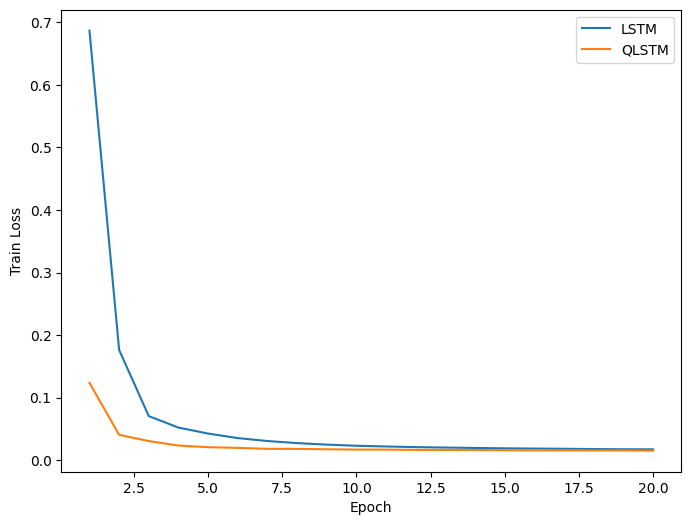

In [120]:
plt.figure(figsize=(8, 6))
plt.plot(range(1,21), classical_loss_train, label = "LSTM")
plt.plot(range(1,21), quantum_loss_train, label = "QLSTM")
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

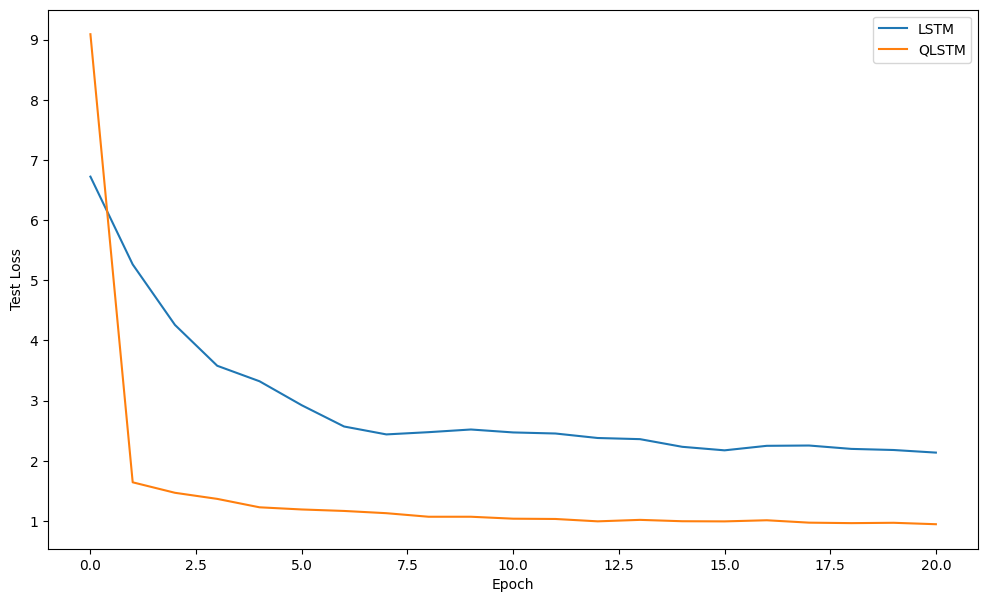

In [121]:
plt.figure(figsize=(12, 7))
plt.plot(range(21), classical_loss_test, label = "LSTM")
plt.plot(range(21), quantum_loss_test, label = "QLSTM")
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Complexity analysis

In [122]:
 total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params_Q = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)

print("No. of parameters for Classical LSTM: ", total_params)
print("No. of parameters for QLSTM: ", total_params_Q)

No. of parameters for Classical LSTM:  2577
No. of parameters for QLSTM:  253
